In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/arpita')

In [3]:
import pandas as pd
data=pd.read_csv('banladesh.csv',index_col='ObservationDate',parse_dates=True)
data.head()

,Confirmed
ObservationDate,
2020-03-08,3
2020-03-09,3
2020-03-10,3
2020-03-11,3
2020-03-12,3


In [ ]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# ARIMA

In [4]:
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller
# create a differenced time series
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return Series(diff)

X = data.values
# difference data
stationary = difference(X)
stationary.index = data.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header=False)

ADF Statistic: -3.711250
p-value: 0.003958
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


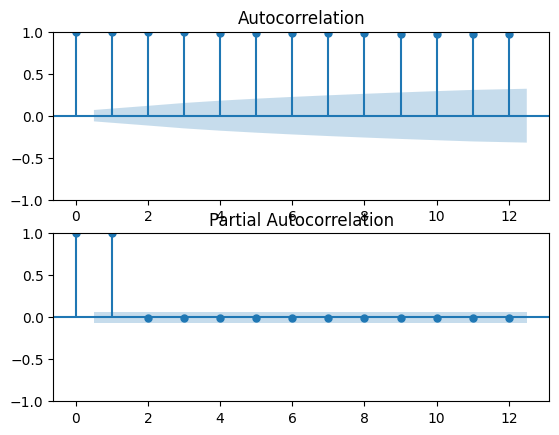

In [7]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure()
pyplot.subplot(211)
plot_acf(data, lags=12, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(data, lags=12, ax=pyplot.gca())
pyplot.show()

#(0,1,1) === 74.42
#(1,1,1) === 42.43
#(2,2,1) === 43.32
#(2,1,1) === 42.247
#(2,1,2) === 42.87
#(2,2,2) === 45.673
#(2,1,3) === 44.196


In [20]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from math import sqrt

# prepare data
X = data.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  model = sm.tsa.arima.ARIMA(history, order=(2,1,3))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat.round())
  # observation
  obs = test[i]
  history.append(obs)
  #print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 44.196


In [21]:
def series_to_supervised(data,n_in,n_out=1):
    df=pd.DataFrame(data)
    cols=list()
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
    
    for i in range(0,n_out):
        cols.append(df.shift(-i))
    
    agg=pd.concat(cols,axis=1)
    agg.dropna(inplace=True)
    return agg  #agg.values

In [22]:
from sklearn.svm import SVR

In [33]:
train=series_to_supervised(data,1)

In [34]:
X,Y=train.iloc[:,:-1],train.iloc[:,-1]

In [35]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y.values,test_size=.1,random_state=101)

In [36]:
model_svr=SVR()
model_svr.fit(x_train,y_train)

SVR()

In [37]:
from sklearn.metrics import mean_squared_error
import numpy as np
y_pred=model_svr.predict(x_test)
# Calculate the RMSE of the predictions
rmse = np.sqrt(mean_squared_error(y_test,y_pred.round()))
print('RMSE: %.2f' % rmse)

RMSE: 691301.37


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Create an SVR model
svr = SVR()

# Define the parameter grid to search over
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 1, 10],
              'kernel': ['linear', 'poly', 'rbf']}

# Perform grid search over the parameter grid
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Print the best parameters and their corresponding mean squared error
print('Best parameters:', grid_search.best_params_)
print('Best mean squared error:', -grid_search.best_score_)